# Final Project
## Krista Miller, Emma Bright

****
### Executive Summary

A diagnosis of pancreatic cancer is almost certainly a death sentence, with an 11% 5-year relative survival rate the chances of making it to a full recovery are extremely slim.  Unfortunately, there is also no isolated diagnostic test, such as a mammogram for breast cancer or colonoscopy for colon cancer, that can help to detect this deadly disease early on. Researchers are still trying to find a way to help predict whether a patient is likely to have pancreatic cancer based on various health indicators.

The objective of this research project is to explore Logistic Regression and Naive Bayes and determine which algorithm is most effective for predicting whether a patient will be diagnosed with pancreatic cancer by utilizing various biomarkers present within a urine sample and a patient's demographic information. 


To achieve this objective, we performed appropriate data preparation methods, such as exploratory analysis, variable selection and encoding of our data, and applied the LinearRegression and MultinomialNB libraries from sklearn.  Our “best fit” model was determined by utilizing GridSearchCV to loop through predefined hyperparameters and fit our model on our training set. 

Our final model results showed that our models were equally effective at predicting whether a patient was likely to be diagnosed with pancreatic cancer. The overall accuracy rate of our models was 84%. 

***

The libraries utilized in our project were imported below. 

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error, classification_report
import sklearn.preprocessing
from sklearn.preprocessing import (LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Binarizer, LabelBinarizer)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.feature_selection import chi2

import warnings
warnings.filterwarnings('ignore')

***
### Data Preparation & Exploratory Analysis
Data preparation is an important part of building any machine learning model.  To properly prepare our data and test for assumptions of our chosen statistical methods, we needed to perform exploratory analysis, variable selection and encode our data.

The data set that we chose consisted of 590 independent samples (obeservations), 13 feature variables consisting of demographic information and urine protein biomarkers, and a single output variable (diagnosis).  According to Kaggle, this data was collected by researchers for the purpose of developing an accurate way to identify patients with pancreatic cancer.  To do this, they collected biomarkers from the urine of three groups of patients (reflected as 1, 2, and 3 respectively in our 'diagnosis' output variable):

- Healthy controls
- Patients with non-cancerous pancreatic conditions, like chronic pancreatitis
- Patients with pancreatic ductal adenocarcinoma

The urinary biomarkers that were measured from these patients were: creatinine, LYVE1, REG1B, and TFF1. These protein biomarkers were selected as they are generally associated with how well a pancreas is functioning.

- Creatinine is a protein that is often used as an indicator of kidney function.
- YVLE1 is lymphatic vessel endothelial hyaluronan receptor 1, a protein that may play a role in tumor metastasis
- REG1B is a protein that may be associated with pancreas regeneration
- TFF1 is trefoil factor 1, which may be related to regeneration and repair of the urinary tract

***

To begin, we read in our dataset and checked that all observations and features were present.

In [6]:
pancreatic = pd.read_csv('pancreaticCA.csv')

print(pancreatic.shape)
pancreatic.head()

(590, 14)


,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


We also checked to determine if NULL values were present within the dataset.  We found that almost half the data was null for the 'stage', 'benign_sample_diagnosis', and 'plasma_CA19_9' features.  Stage, Benign Sample Diagnosis and Plasma CA19 are variables that are associated only with their respective diagnoses.  For example, information for the 'stage' variable would only have been collected for a patient who had confirmed pancreatic cancer.  Therefore, we determined these columns would be dropped later. 

In [7]:
pancreatic.isna().sum()

sample_id                    0
patient_cohort               0
sample_origin                0
age                          0
sex                          0
diagnosis                    0
stage                      391
benign_sample_diagnosis    382
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
dtype: int64

The plot below shows a visual representation of these NULL values.

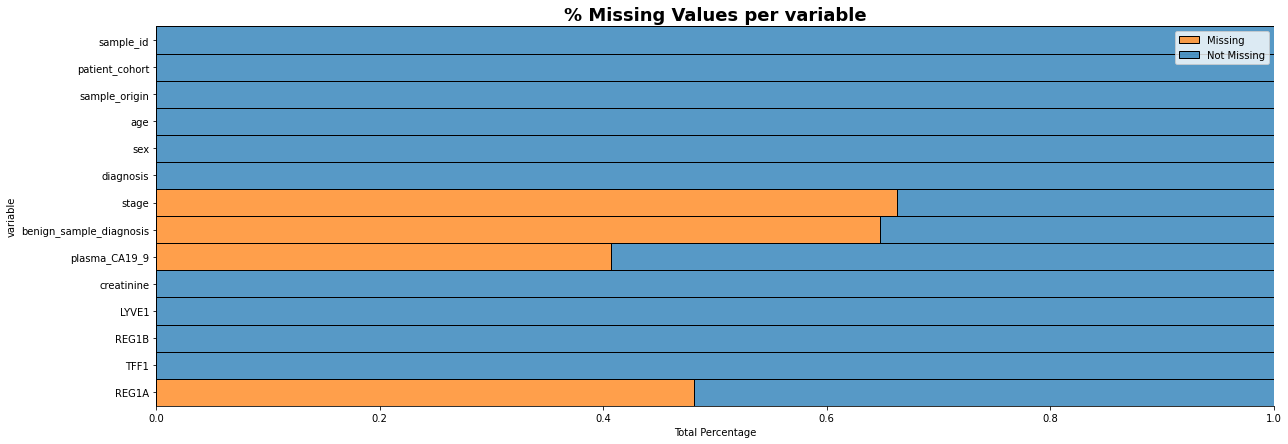

In [8]:
sns.displot(
    data=pancreatic.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=3,
    height=6,
    legend=False,
    )

plt.title("% Missing Values per variable", size=18, weight="bold")
plt.xlabel("Total Percentage")
plt.legend(["Missing", "Not Missing"]);
plt.show()

In addition to the NULL fields we also chose to drop columns related to the sample ID and the patient cohort.  The table below shows our dataset after the appropriate fields were removed. 

In [9]:
pancreatic = pancreatic[[ 'sample_origin', 'age', 'sex', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'diagnosis']]
pancreatic.head()

,sample_origin,age,sex,creatinine,LYVE1,REG1B,TFF1,diagnosis
0,BPTB,33,F,1.83222,0.893219,52.94884,654.282174,1
1,BPTB,81,F,0.97266,2.037585,94.46703,209.488250,1
2,BPTB,51,M,0.78039,0.145589,102.36600,461.141000,1
3,BPTB,61,M,0.70122,0.002805,60.57900,142.950000,1
4,BPTB,62,M,0.21489,0.000860,65.54000,41.088000,1


We also used the describe function to see how the numerical features within our dataset were dispersed.  Upon evaluating the output of the describe function we decided that it would be better to use the StandardScaler package within the sklearn library to transform each of these features.  Standard scaling allows us to remove any bias from our model that may be imparted by large values from the protein biomarkers, and allows each variable to be weighed more equally. 

In [10]:
pancreatic.describe()

,age,creatinine,LYVE1,REG1B,TFF1,diagnosis
count,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000
mean,59.079661,0.855383,3.063530,111.774090,597.868722,2.027119
std,13.109520,0.639028,3.438796,196.267110,1010.477245,0.804873
min,26.000000,0.056550,0.000129,0.001104,0.005293,1.000000
25%,50.000000,0.373230,0.167179,10.757216,43.961000,1.000000
50%,60.000000,0.723840,1.649862,34.303353,259.873974,2.000000
75%,69.000000,1.139482,5.205037,122.741013,742.736000,3.000000
max,89.000000,4.116840,23.890323,1403.897600,13344.300000,3.000000


In [11]:
pancreatic[['age', 'creatinine', 'LYVE1', 'REG1B', 'TFF1']] = StandardScaler().fit_transform(pancreatic[['age', 'creatinine', 'LYVE1', 'REG1B', 'TFF1']])
pancreatic.head()

,sample_origin,age,sex,creatinine,LYVE1,REG1B,TFF1,diagnosis
0,BPTB,-1.991056,F,1.529927,-0.631661,-0.299975,0.055876,1
1,BPTB,1.673512,F,0.183680,-0.298597,-0.088256,-0.384680,1
2,BPTB,-0.616843,M,-0.117454,-0.849256,-0.047976,-0.135425,1
3,BPTB,0.146609,M,-0.241451,-0.890812,-0.261065,-0.450584,1
4,BPTB,0.222954,M,-1.003143,-0.891378,-0.235767,-0.551475,1


We also needed to create separate binary column indicators for our sample origin feature. This transformation can be seen below. 

In [12]:
pancreatic.sex = np.where(
        (pancreatic.sex == 'M'), 0, 1)

pancreatic = pd.get_dummies(data=pancreatic, drop_first=True)
    
pancreatic.head()

,age,sex,creatinine,LYVE1,REG1B,TFF1,diagnosis,sample_origin_ESP,sample_origin_LIV,sample_origin_UCL
0,-1.991056,1,1.529927,-0.631661,-0.299975,0.055876,1,0,0,0
1,1.673512,1,0.183680,-0.298597,-0.088256,-0.384680,1,0,0,0
2,-0.616843,0,-0.117454,-0.849256,-0.047976,-0.135425,1,0,0,0
3,0.146609,0,-0.241451,-0.890812,-0.261065,-0.450584,1,0,0,0
4,0.222954,0,-1.003143,-0.891378,-0.235767,-0.551475,1,0,0,0


Finally, we took a look at our output varaible. As mentioned earlier, our output variable contained 3 responses: 

- 1: No pancreatic cancer or pancreatic disease (a healthy pancreas)
- 2: Pancreatic Disease, but no cancer
- 3: Pancreatic Cancer

For our model, we only wanted to identify those patients that had cancer, not those who had pancreatic disease, so we chose to relabel our output variable as follows:

- 0: No pancreatic cancer OR pancreatic disease, but no cancer. 
- 1: Pancreatic cancer.

The code and tables below show this manipulation and the results of our final output variable. 

In [13]:
pancreatic.diagnosis.value_counts()

2    208
3    199
1    183
Name: diagnosis, dtype: int64

In [14]:
pancreatic.diagnosis = np.where((
        (pancreatic.diagnosis == 1) | 
        (pancreatic.diagnosis == 2)), 0, 1)

pancreatic.diagnosis.value_counts()

0    391
1    199
Name: diagnosis, dtype: int64

We also used visual plots to try to identify correlation between our output variable and various feature variables in this exploratory analysis phase. 

The plot below shows how our diagnosis output variable was distributed amongst the sex of patients. 

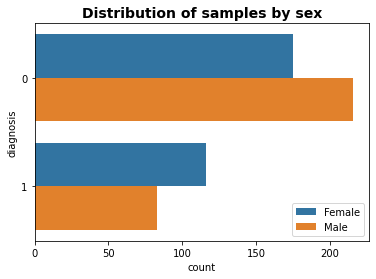

In [15]:
ax = sns.countplot(y="diagnosis", hue = "sex", data = pancreatic)
plt.title("Distribution of samples by sex", size=14, weight="bold")
plt.legend(["Female", "Male"])
plt.show()

This next plot shows how our diagnosis output variable was distributed amongst the age of patients. Age is normally distributed among the diagnosis=0 cohortt, while pancreatic cancer cohort slightly skews left. 

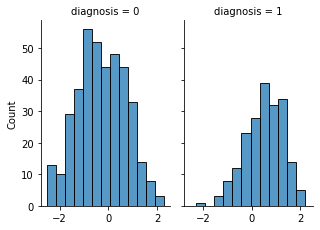

In [17]:
g = sns.FacetGrid(pancreatic, col="diagnosis", height=3.5, aspect=.65)
g.map(sns.histplot, "age")
g.set(xlabel=None)
plt.show()

#### Train-Test Split

The train-test split procedure is used to evaluate the performance of a machine learning model.  

The training set and test set are separate subsets of a full dataset used for model building and evaluation. For example, to build a model and evaluate it’s performance a dataset may be split into 70% training data (training set) and 30% test data (test set). The training set is the generally the largest subset or sample of the dataset and it is used for building the predictive model on the dataset.  The test set is a smaller sample of data used to provide an evaluation of the final model fit on the training dataset – after any parameters have been tuned using the validation set evaluation.

For our project we chose a 70-30 split for our training and test data. 

In [18]:
X = pancreatic[['age', 'sex', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'sample_origin_ESP', 'sample_origin_LIV', 'sample_origin_UCL']]
y = pancreatic['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(f'X_train:\n {X_train.shape}\n')
print(f'X_test:\n {X_test.shape}\n')

print(f'y_train:\n {y_train.shape}\n')
print(f'y_test:\n {y_test.shape}\n')

X_train:
 (413, 9)

X_test:
 (177, 9)

y_train:
 (413,)

y_test:
 (177,)



### Machine Learning Models

For our project we will be exploring the Logistic Regression and Naive Bayes classification algorithms. 

Logistic Regression and Naive Bayes are both linear classification learning algorithms, however, they differ in their methods of implementation and use. 

Logistic regression is a linear classification method used to understand the relationship between the dependent variable, predictor, and one or more independent variables, features, by estimating the probabilities using a logistic regression equation. Logistic regression is generally used to determine the likelihood of binomial outcomes, yes and no, given the set of independent features. The basic assumption of logistic regression is that all observations and features are independent.

Naïve bayes is a set of classification methods based on Bayes’ theorem that use the “naïve” assumption that all features are independent.  Bayes’ theorem states that we can find the probability of an event happening (outcome variable) given an event B (set of independent features) has occurred.  Naïve Bayes also assumes that each feature has an equal importance in determining the probability of the outcome.  Naïve Bayes is a popular method for classifying categorical features and, like Logistic Regression, is usually used to determine a binary, yes/no, outcome variable. 

While both predictive learning algorithms perform well on most datasets, there are certain situations in which one algorithm may perform better than the other. Logistic Regression is better suited to datasets with large sample sizes and Naïve Bayes performs better with high-dimensional datasets. This makes it especially interesting for our project as we have both low-dimensional data and a small number of observations (less than 1000). 

Additionally, even though both algorithms are used to classify data, the way the algorithms compute probabilities to determine the class of the data is different.  Naïve Bayes is considered a generative model where the outcome is learned using a joint probability distribution, P(x,y).  Logistic Regression is a discriminative model where the outcome is learned using a conditional probability distribution, P(Y|X=x).

### Logistic Regression

We began our exploration of these models with Logistic Regression.  As stated above, Logistic Regression has two major assumptions:
- Indepdence of observations
- Indepdence of feature variables (little multicollinearity)

Fortunately, each of the samples within our data was collected from a different patient, and thus our observations were independent, however, we still needed to check that our feature variables were not highly correlated. 

The correlation plot below allowed us to check the collinearity of variables and gave us assurance that the assumption was satisfied.

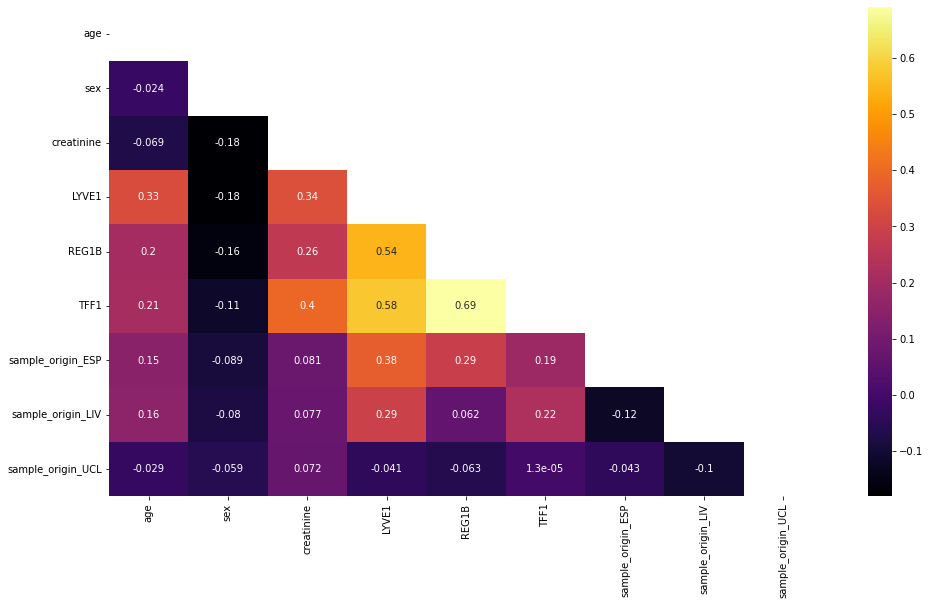

In [19]:
## multicollinearity 
plt.figure(figsize=(16,9))
corr_mx = X.corr()
matrix = np.triu(corr_mx)  
sns.heatmap(corr_mx, cmap="inferno", mask=matrix, annot = True)
plt.show()

#### Build Logistic Regression Model

Our data has been cleaned, scaled, and split into training and test datasets and we have checked for all assumptions required by our classifcation method, so we are now free to build the logistic regression model. 

To begin, we created a model with no additional hyper parameter tuning. This model was able to accurately predict the diagnosis of pancreatic cancer patients at 84.745%. 

In [20]:
# create logistic regression object
reg = LogisticRegression()
   
# train the model using the training sets
reg.fit(X_train, y_train)
  
# making predictions on the testing set
y_pred = reg.predict(X_test)
   
# comparing actual response values (y_test) with predicted response values (y_pred)
print("Logistic Regression model accuracy(in %):", 
metrics.accuracy_score(y_test, y_pred)*100)

Logistic Regression model accuracy(in %): 84.7457627118644


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       125
           1       0.75      0.73      0.74        52

    accuracy                           0.85       177
   macro avg       0.82      0.81      0.82       177
weighted avg       0.85      0.85      0.85       177



We then performed hyperparameter tuning with GridSearchCV to see if we could increase the overall accuracy of our Logistic Regression model. The parameters that we chose to tune tested for different model variations with respect to type of regularization, size of penalty, and type of solver used.

In [22]:
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

grid_clf = GridSearchCV(reg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

grid_clf.fit(X_train, y_train)
print("Tuned Hyperparameters :", grid_clf.best_params_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


We then plugged in the defined hyperparameters in our model and retested the accuracy and classifaction report for our model. Interestingly, our model performed with the exact same effectiveness. 

In [23]:
# create logistic regression object
reg = LogisticRegression(C=1, penalty='l2', solver='liblinear')
   
# train the model using the training sets
reg.fit(X_train, y_train)
  
# making predictions on the testing set
y_pred = reg.predict(X_test)
   
# comparing actual response values (y_test) with predicted response values (y_pred)
print("Logistic Regression model accuracy(in %):", 
metrics.accuracy_score(y_test, y_pred)*100)

Logistic Regression model accuracy(in %): 84.7457627118644


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       125
           1       0.75      0.73      0.74        52

    accuracy                           0.85       177
   macro avg       0.82      0.81      0.82       177
weighted avg       0.85      0.85      0.85       177



### Naive Bayes

We then explored the Naive Bayes classification algorithm. Naive Bayes has only a single assumption, and that is that all features are indepdendent.  Thankfully, we had checked for this same assumption with our Logistic Regression model and it was shown that our featueres were, in fact, indepdendent. 

To begin, we created a model with no additional hyper parameter tuning. This model was able to accurately predict the diagnosis of pancreatic cancer patients at 42.372%, which is a very low performance. 

In [25]:
nb = GaussianNB()
nb.fit(X_train, y_train)

# making predictions on the testing set
y_pred = nb.predict(X_test)
   
# comparing actual response values (y_test) with predicted response values (y_pred)
print("Naive Bayes model accuracy(in %):", 
metrics.accuracy_score(y_test, y_pred)*100)

Naive Bayes model accuracy(in %): 42.3728813559322


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31       125
           1       0.34      1.00      0.50        52

    accuracy                           0.42       177
   macro avg       0.67      0.59      0.41       177
weighted avg       0.81      0.42      0.37       177



We then performed hyperparameter tuning with GridSearchCV to see if we could increase the overall accuracy of our Naive Bayes model. 

In [30]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nb_grid = GridSearchCV(nb, 
                       param_grid=param_grid_nb, 
                       verbose=1, 
                       cv=10)
nb_grid.fit(X_train, y_train)
print("Tuned Hyperparameters :", nb_grid.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned Hyperparameters : {'var_smoothing': 0.0012328467394420659}


"The variable, var_smoothing, artificially adds a user-defined value to the distribution's variance (whose default value is derived from the training data set). This essentially widens (or "smooths") the curve and accounts for more samples that are further away from the distribution mean." 

This variable smoothing actually made our Gaussian Naive Bayes and Logistic Regression models perform equally as well. 

In [32]:
nb = GaussianNB(var_smoothing=0.0012328467394420659)
nb.fit(X_train, y_train)

# making predictions on the testing set
y_pred = nb.predict(X_test)
   
# comparing actual response values (y_test) with predicted response values (y_pred)
print("Naive Bayes model accuracy(in %):", 
metrics.accuracy_score(y_test, y_pred)*100)

Naive Bayes model accuracy(in %): 84.7457627118644


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       125
           1       0.75      0.73      0.74        52

    accuracy                           0.85       177
   macro avg       0.82      0.81      0.82       177
weighted avg       0.85      0.85      0.85       177



## Conclusion
After tuning the logistic regression and naive bayes model hyperparameters, we evaluated the performance metrics.  Interestingly, both models resulted in equivalent metrics on the classification reports. 

Precision is the ability of a classifier not to label an instance positive that is actually negative.  This is an important metric when evaluating a model for pancreatic cancer classification, because we do not want our model to label a patient as positive for pancreatic cancer who is not actually sick.  In practice, we assume that a false positive would result in further diagnostic work up before immediately initiating an agressive treatment plan.  

Recall is the ability of a classifier to find all positive instances. This is another important consideration for a model that is classifying a disease with such a high mortality rate.  We want to optimize this metric to make sure we are capturing as many actual positives as possible, since the function of our algorithm is to help identify pancreatic disease early.  

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. This metric is helpful to compare the effectiveness of different machine learning models.  The F1 scores were equivalent for our models.  

This case highlights how machine learning can bring hopeful applications to some difficult problems in healthcare.  In practice, deploying machine learning algorithms that impact humans should be developed on larger cohorts to improve statistical power, involve experts to understand possible confounding variables or outliers, and ethics consultations to verify the appropriateness and consequences of machine learning models in clinical practice.  